In [2]:
import numpy as np
from mountain import *
import matplotlib.pyplot as plt


adad c:\Users\somme\OneDrive - University of Bergen\Uib\Master\Inf266\Reinforcement-learning\assignment2


In [3]:
# env = Mountain_one()

Run policy evaluation straight left to right

In [ ]:
env = Mountain_one()
ROWS, COLS = env.get_map().shape

def straight_policy(order="rtl", gamma = 1):
    V = np.zeros((ROWS, COLS))

    if order == "rtl":      # right -> left
        col_range = range(COLS-1, -1, -1)
    else:                   # left -> right
        col_range = range(COLS)

    for j in col_range:
        for i in range(ROWS):

            if j == COLS-1:   # terminal column
                continue

            s = (i, j)
            a = "forward"

            next_s = env.next_state(s, a)
            r = env.get_reward(s, a)

            V[s] = r + gamma * V[next_s]

    return V


V_rtl_1 = straight_policy("rtl")
V_ltr_1 = straight_policy("ltr")

print("RTL after 1 sweep:\n", V_rtl_1[0][0])
print("LTR after 1 sweep:\n", V_ltr_1[0][0])

RTL after 1 sweep:
 -67.43137399
LTR after 1 sweep:
 -0.7843138


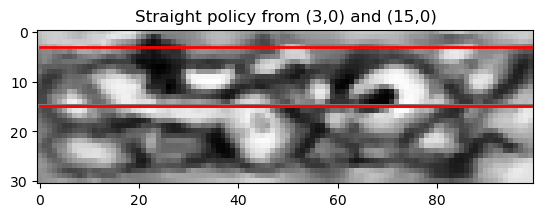

In [9]:
terrain = env.get_map()

plt.imshow(terrain, cmap='gray')
plt.title("Straight policy from (3,0) and (15,0)")

# trajectory coordinates
start_row = 15
cols = list(range(COLS))
rows_1 = [15] * COLS
rows_2 = [3] * COLS


plt.plot(cols, rows_1, color='red', linewidth=2)
plt.plot(cols, rows_2, color='red', linewidth=2)

plt.show()

Task 7

In [ ]:
starting_pos = []
for row in range(ROWS):
    starting_pos.append(float(V_rtl_1[row][0]))
print("starting positions:", starting_pos)
best_start = max(starting_pos)
print(f"The best value startpos: {best_start}, row: {starting_pos.index(best_start)}")


starting positions: [-67.43137399, -61.658825500000006, -56.384315619999995, -52.796080069999995, -49.129413629999995, -43.83921732999998, -37.35294258499998, -35.72156986299999, -43.27843296699998, -49.34902137899999, -51.376472048999986, -49.17647173200002, -45.356863945, -48.21176585100001, -54.945099794, -57.80784459, -60.39215865999999, -60.69019825, -52.48235468000001, -44.72549154000001, -41.91372676999999, -42.4627465, -44.909805005, -45.25882518499999, -45.027452619999984, -42.85882514499999, -38.482354210000004, -38.00392276, -45.564707059999975, -54.09804133999999, -60.38431538]
The best value startpos:-35.72156986299999, row: 7


Task 8

In [17]:
def random_policy_evaluation(gamma=1.0, theta=1e-6):
    V = np.zeros((ROWS, COLS))

    while True:
        delta = 0

        for j in range(COLS-1, -1, -1):
            for i in range(ROWS):

                if j == COLS-1:
                    continue

                s = (i, j)

                new_v = 0
                for a in env.actions:  # expectation over actions
                    next_s = env.next_state(s, a)
                    r = env.get_reward(s, a)
                    new_v += (1/3) * (r + gamma * V[next_s])

                delta = max(delta, abs(new_v - V[s]))
                V[s] = new_v

        if delta < theta:
            break

    return V

General policy evaluation with order parameter

In [18]:
V_random = random_policy_evaluation()
print(V_random[0])

[-54.29929304 -53.66220567 -53.00486544 -52.33797521 -51.66659327
 -51.01549512 -50.39670889 -49.80690099 -49.24699389 -48.67266363
 -48.06274762 -47.43457336 -46.83219237 -46.250278   -45.65585808
 -45.02208503 -44.37897522 -43.74101425 -43.10377411 -42.49817503
 -42.03267501 -41.66498426 -41.38007913 -41.14635059 -40.86529071
 -40.50065029 -40.10085529 -39.67706519 -39.238716   -38.79215001
 -38.32988298 -37.85227337 -37.33324279 -36.76258014 -36.1503204
 -35.51342277 -34.86815575 -34.2247488  -33.60161818 -33.00241072
 -32.44405178 -31.92800921 -31.43437355 -30.9830859  -30.59986286
 -30.24797503 -29.86537073 -29.39388363 -28.92829986 -28.52440344
 -28.1205486  -27.69397543 -27.2356965  -26.75469765 -26.27826317
 -25.80521688 -25.3271289  -24.84619162 -24.36547291 -23.8774369
 -23.36444321 -22.812298   -22.23348481 -21.63064013 -21.00995492
 -20.37568804 -19.73748012 -19.08801167 -18.42664525 -17.75274055
 -17.06719915 -16.37605379 -15.69486351 -15.02852703 -14.39483381
 -13.7887950

Find a trajectory starting at a given state.

In [19]:
def sample_random_trajectory(start):
    trajectory = [start]
    s = start

    while s[1] < COLS-1:   # until last column
        a = np.random.choice(env.actions)
        s = env.next_state(s, a)
        trajectory.append(s)

    return trajectory

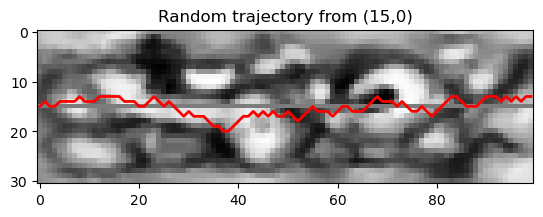

In [25]:
traj = sample_random_trajectory((15,0))

rows = [s[0] for s in traj]
cols = [s[1] for s in traj]

plt.imshow(env.get_map(), cmap="gray", origin="upper")
plt.plot(cols, rows, color="red", linewidth=2)

plt.title("Random trajectory from (15,0)")
plt.show()

In [6]:
def policy_evaluation(env, pi, gamma = 1, theta = 0.0001, order = "rtl"):
    ...
    return 